In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from copy import deepcopy as dc
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import import_ipynb
from helpers import train_and_validate, count_parameters, plot_loss_comparison, plot_test_predictions, compare_mse_loss
import time
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

importing Jupyter notebook from helpers.ipynb


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
window_size = 24
batch_size = 100
input_size = 1
hidden_size = 100
num_classes = 1
learning_rate = 0.001
epochs = 200
criterion = nn.MSELoss()

In [4]:
def root_mean_squared_error(actual, predicted):
    actual = torch.tensor(actual, dtype=torch.float32)
    predicted = torch.tensor(predicted, dtype=torch.float32)
    
    if actual.shape != predicted.shape:
        raise ValueError("Tensors must have the same shape.")
    
    mse = torch.mean((actual - predicted)**2)
    
    return (mse.item() ** 0.5)

In [5]:
df = pd.read_csv("../data/clean_data.csv")
df = df[:-24]
df.shape

(15955, 5)

In [6]:
df = df[["Date", "P (kW)"]]
train_df = df.iloc[:-24]
test = df.iloc[-24:]

In [7]:
def prepare_dataframe(df, n_steps):
    df = dc(df)
    
    df.set_index('Date', inplace=True)
    
    for i in range(1, n_steps+1):
        df[f'P (kW)(t-{i})'] = df['P (kW)'].shift(i)
        
    df.dropna(inplace=True)
    
    return df

In [8]:
new_df = prepare_dataframe(train_df, window_size)
new_df = new_df.to_numpy()
new_df

array([[  0.        ,   0.        ,   0.        , ...,  14.75265   ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ..., 127.16308333,
         14.75265   ,   0.        ],
       [ 16.82213636,   0.        ,   0.        , ..., 302.4557    ,
        127.16308333,  14.75265   ],
       ...,
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]])

In [9]:
X = new_df[:, 1:]
y = new_df[:, 0]

In [10]:
X.shape, y.shape

((15907, 24), (15907,))

In [11]:
split_index = int(len(X) * 0.9)

In [12]:
X_train = X[:split_index]
X_val = X[split_index:]

y_train = y[:split_index]
y_val = y[split_index:]

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((14316, 24), (1591, 24), (14316,), (1591,))

In [13]:
X_train = X_train.reshape((-1, window_size, 1))
X_val = X_val.reshape((-1, window_size, 1))

y_train = y_train.reshape((-1, 1))
y_val = y_val.reshape((-1, 1))

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((14316, 24, 1), (1591, 24, 1), (14316, 1), (1591, 1))

In [14]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_val = torch.tensor(X_val).float()
y_val = torch.tensor(y_val).float()

X_train.shape, X_val.shape, y_train.shape, y_val.shape

(torch.Size([14316, 24, 1]),
 torch.Size([1591, 24, 1]),
 torch.Size([14316, 1]),
 torch.Size([1591, 1]))

In [15]:
class SolarData(Dataset):

    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [16]:
train = SolarData(X_train, y_train)
val = SolarData(X_val, y_val)

In [17]:
train_loader = DataLoader(train, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val, batch_size = batch_size, shuffle = False)

In [18]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([100, 24, 1]) torch.Size([100, 1])


In [19]:
class CustomNet(nn.Module):

    def __init__(self, input_size: int, hidden_size: int, num_classes: int):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.W = nn.Parameter(torch.Tensor(input_size, input_size), requires_grad = True)
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first = True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = torch.tanh(x @ self.W)
        x_, (h_t, c_t) = self.lstm(x)
        out = self.fc(x_[:, -1, :])
        return out

In [20]:
customnet = CustomNet(input_size, hidden_size, num_classes).to(device)
customnet_optimizer = torch.optim.Adam(customnet.parameters(), lr = learning_rate)

In [21]:
total_customnet_parameters = count_parameters(customnet)

In [22]:
customnet_train_loss_array = []
customnet_val_loss_array = []

In [23]:
customnet_start_time = time.time()
train_and_validate(epochs, device, customnet, train_loader, val_loader, criterion, customnet_optimizer, customnet_train_loss_array, customnet_val_loss_array)
customnet_end_time = time.time()
customnet_total_training_time = customnet_end_time - customnet_start_time
customnet_avg_training_time_per_epoch = customnet_total_training_time / epochs

Epoch no.: 1 | Training Loss: 83757.59657118056 | Validation Loss: 25215.14178466797
Epoch no.: 2 | Training Loss: 78601.26698133681 | Validation Loss: 23526.853546142578
Epoch no.: 3 | Training Loss: 74593.63034396702 | Validation Loss: 22345.80404663086
Epoch no.: 4 | Training Loss: 70870.0239054362 | Validation Loss: 21587.571838378906
Epoch no.: 5 | Training Loss: 68420.26633029514 | Validation Loss: 21163.889282226562
Epoch no.: 6 | Training Loss: 66123.17499457466 | Validation Loss: 21018.991149902344
Epoch no.: 7 | Training Loss: 63913.871690538195 | Validation Loss: 21108.47006225586
Epoch no.: 8 | Training Loss: 62394.870768229164 | Validation Loss: 21391.232971191406
Epoch no.: 9 | Training Loss: 60905.779595269094 | Validation Loss: 21825.360717773438
Epoch no.: 10 | Training Loss: 59631.83977593316 | Validation Loss: 22369.214965820312
Epoch no.: 11 | Training Loss: 59281.991048177086 | Validation Loss: 22989.294982910156
Epoch no.: 12 | Training Loss: 58399.78569878472 | V

In [24]:
print()
print()
print("------------------------------------------------------------")
print(f"Total Parameters:     CustomNet: {total_customnet_parameters}")
print()
print(f"Total Training Time:     CustomNet: {customnet_total_training_time:.2f}s")
print()
print(f"Average Training Time Per Epoch:     CustomNet: {customnet_avg_training_time_per_epoch:.2f}s")

print("------------------------------------------------------------")



------------------------------------------------------------
Total Parameters:     CustomNet: 41302

Total Training Time:     CustomNet: 633.04s

Average Training Time Per Epoch:     CustomNet: 3.17s
------------------------------------------------------------


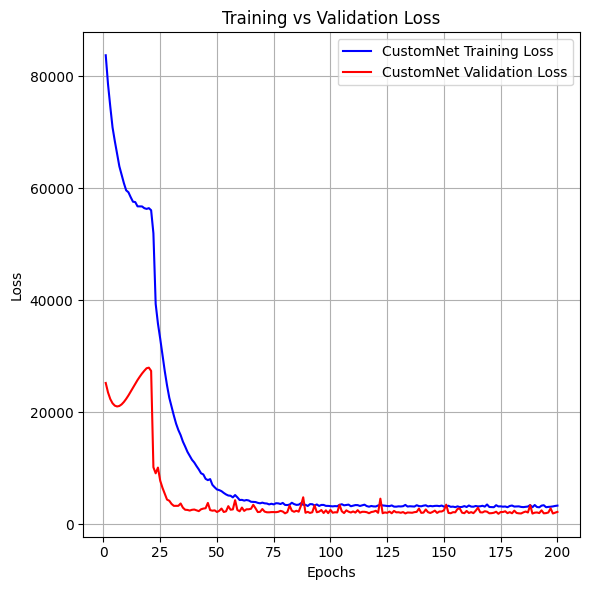

In [25]:
plot_loss_comparison(epochs, customnet_train_loss_array, customnet_val_loss_array, "CustomNet Training Loss", "CustomNet Validation Loss", "Training vs Validation Loss")

In [26]:
customnet.eval()
last_24_values_test = y_val[-window_size:]
last_24_values_test = torch.tensor(last_24_values_test, dtype=torch.float32).unsqueeze(0).to(device)
predictions_test = []

for i in range(window_size):
    # Make the prediction
    with torch.no_grad():
        pred_test = customnet(last_24_values_test)
    
    # Store the prediction
    predictions_test.append(pred_test.item())
    
    # Shift the values to the left and add the predicted value to the last_24_values_test for the next iteration
    last_24_values_test = torch.cat((last_24_values_test[:, 1:], pred_test.unsqueeze(1)), dim=1)

# Convert predictions_test to a numpy array
predictions_test = np.array(predictions_test)

C:\Users\itadmin\AppData\Local\Temp\ipykernel_8180\1908420732.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  last_24_values_test = torch.tensor(last_24_values_test, dtype=torch.float32).unsqueeze(0).to(device)


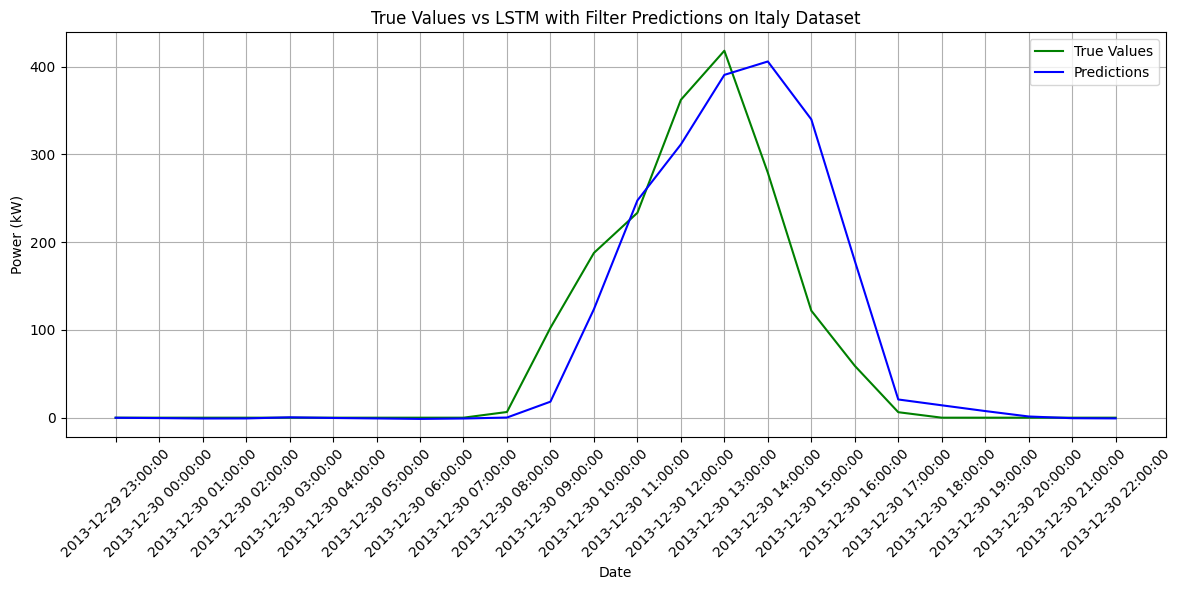

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(test['Date'], test['P (kW)'], 'g', label='True Values')
plt.plot(test['Date'], predictions_test, 'b', label='Predictions')
plt.title('True Values vs LSTM with Filter Predictions on Italy Dataset')
plt.xlabel('Date')
plt.ylabel('Power (kW)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [28]:
mse = root_mean_squared_error(test["P (kW)"].values, predictions_test)
r2 = r2_score(test["P (kW)"].values, predictions_test)
print(f"Mean Squared Error: {mse}")
print(f'R-squared value: {r2}')

Mean Squared Error: 62.30938314985653
R-squared value: 0.7489903795471812
